# **NETFLIX RECOMENDATION**

# **1. INTRODUCCIÓ**

### **IMPORTS** 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import seaborn as sns
from wordcloud import WordCloud

# **2. EDA**

### **2.1 LECTURA DEL DATASET** 

Primerament, descarreguem el Dataset i el visualitzem.

In [2]:
file_path_test = 'C:\\Users\\USER\\Desktop\\3r\\1r semestre\\Aprenentatge Computacional\\Kaggle\\netflix_titles.csv'

df_1 = pd.read_csv(file_path_test)

In [116]:
# Funció per expandir columnes
def expand_dataframe(df, columns_to_expand):
    """
    Expandeix les columnes especificades en un DataFrame, creant una fila per cada element a les llistes.
    :param df: DataFrame original.
    :param columns_to_expand: Columnes que contenen llistes separades per comes.
    :return: DataFrame expandit.
    """
    # Substituïm valors nuls amb cadenes buides per processar
    expanded_df = df.copy()
    for column in columns_to_expand:
        expanded_df[column] = expanded_df[column].fillna("").apply(lambda x: [item.strip() for item in x.split(",") if item.strip()])

    # Explosió de columnes
    for column in columns_to_expand:
        expanded_df = expanded_df.explode(column, ignore_index=True)

    # Tornem a posar valors nuls per coherència
    for column in columns_to_expand:
        expanded_df[column] = expanded_df[column].replace("", pd.NA)
    
    return expanded_df


# Columnes a expandir
columns_to_expand = ['cast', 'director', 'country', 'listed_in']

# Aplicar la funció per expandir
df = expand_dataframe(df_1, columns_to_expand)

# Guardar el resultat en un nou fitxer (opcional)
expanded_file_path = 'C:\\Users\\USER\\Desktop\\3r\\1r semestre\\Aprenentatge Computacional\\Kaggle\\dataset_nou'

df.to_csv(expanded_file_path, index=False)

print(f"Dataset expandit i desat a: {expanded_file_path}")


Dataset expandit i desat a: C:\Users\USER\Desktop\3r\1r semestre\Aprenentatge Computacional\Kaggle\dataset_nou


### **2.2 EXPLORACIÓ DE LES DADES**

In [61]:
print(f'El nostre dataset té {df.shape[0]} files i {df.shape[1]} columnes.\n')
print("Observem les 10 primeres files del dataset:")
df.head(10)
print(df.keys())
print(  )
print ('Tipus atributs:')
print (df.dtypes)

El nostre dataset té 201959 files i 12 columnes.

Observem les 10 primeres files del dataset:
Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

Tipus atributs:
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


Els atributs que tenim són:

* *show_id*: Identificador únic per a cada títol de Netflix.
* *type*: Tipus de contingut, especificant si és una "Movie" (pel·lícula) o un "TV Show" (programa de televisió).
* *title*: Títol de la pel·lícula o programa de televisió.
* *director*: Nom del director/directora de la producció. 
* *cast*: Llista dels actors principals que apareixen en el contingut.
* *country*: País o països on s'ha produït la pel·lícula o programa de televisió.
* *date_added*: Data en què el títol es va afegir a Netflix.
* *release_year*: Any en què es va estrenar el contingut.
* *rating*: Classificació de l'edat recomanada per al contingut.
* *duration*: Durada de la pel·lícula (en minuts) o nombre de temporades (seasons) per a programes de televisió.
* *listed_in*: Categories o gèneres en què el títol està classificat, com "Documentaries", "TV Dramas", etc.
* *description*: Breu descripció o sinopsi del contingut

In [62]:
print("Hi ha", len(df.type.value_counts()), "tipus de contingut.")
print("Hi ha", len(df.title.value_counts()), "diferents títols.") 

directors = df['director'].str.split(', ').explode().value_counts()
print("Hi ha", directors.count(), "diferents directors.")

artistes = df['cast'].str.split(', ').explode().value_counts()
print("Hi ha", artistes.count(), "diferents artistes.")

pais = df['country'].str.split(', ').explode().value_counts()
print("Hi ha", pais.count(), "paisos.")

print("Hi ha", len(df.date_added.value_counts()), "diferents dates en que es van afegir a netflix.")
print("Hi ha", len(df.release_year.value_counts()), "diferents anys en que es va estrenar el contingut.") 
print("Hi ha", len(df.rating.value_counts()), "classificacions per la recomenació d'edats pel contingut.")
print("Hi ha", len(df.duration.value_counts()), "diferentes duracions.") 

categories = df['listed_in'].str.split(', ').explode().value_counts()
print("Hi ha", categories.count(), "categories diferents.\n")

Hi ha 2 tipus de contingut.
Hi ha 8807 diferents títols.
Hi ha 4993 diferents directors.
Hi ha 36439 diferents artistes.
Hi ha 122 paisos.
Hi ha 1767 diferents dates en que es van afegir a netflix.
Hi ha 74 diferents anys en que es va estrenar el contingut.
Hi ha 14 classificacions per la recomenació d'edats pel contingut.
Hi ha 220 diferentes duracions.
Hi ha 42 categories diferents.



In [63]:
classificacio = df['rating'].unique()
print(classificacio)

['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'
 'NC-17' nan 'NR' 'TV-Y7-FV' 'UR']


Els possibles significats de l'atribut *rating* són els següents:

1. **PG-13: Advertència per als pares (Parents Strongly Cautioned)**. Per a majors de 13 anys; pot tenir contingut inapropiat per a menors de 13. Inclou temes de violència o llenguatge moderat.

2. **TV-MA: Audiència madura (Mature Audience)**. Només per a adults, 17 anys o més. Inclou contingut explícit de violència, llenguatge fort o sexualitat.

3. **PG: Supervisió parental (Parental Guidance)**. Recomanat amb supervisió d’un adult. Pot no ser adequat per a nens petits, amb contingut de violència lleu o llenguatge moderat.

4. **TV-14: Advertència per als pares (Parents Strongly Cautioned)**. No recomanat per a menors de 14 anys sense supervisió d'un adult. Pot incloure violència o temes madurs.

5. **TV-PG: Supervisió parental suggerida (Parental Guidance Suggested)**. Pot no ser adequat per a nens petits; pot incloure llenguatge o temes lleus.

6. **TV-Y: Per a tots els nens (All Children)**. Adequat per a nens de totes les edats, sense violència ni llenguatge inapropiat.

7. **TV-Y7: Dirigit a nens més grans (Directed to Older Children)**. Adequat per a nens de 7 anys en endavant; podria incloure violència lleu de fantasia.

8. **R: Restringit (Restricted)**. Només per a majors de 17 o 18 anys, degut a violència intensa, contingut sexual o llenguatge explícit.

9. **TV-G: Audiència general (General Audience)**. Per a tot el públic, sense contingut objectable.

10. **G: Audiència general (General Audiences)**. Apte per a totes les edats, similar a TV-G.

11. **NC-17: Només per a adults (Adults Only)**. Contingut molt explícit, no apte per a menors de 17 anys, comú en cinema.

12. **NR: Sense classificar (Not Rated)**. No ha estat classificat oficialment, podria tenir qualsevol tipus de contingut.

13. **TV-Y7-FV: Dirigit a nens més grans amb violència de fantasia (Directed to Older Children - Fantasy Violence)**. Adequat per a majors de 7 anys, amb violència de fantasia que pot ser intensa per als més petits.

14. **UR: Sense classificació (Unrated)**. No té una classificació oficial; pot incloure qualsevol tipus de contingut.

Un cop observades les dades prenem les decisions següents:

*   *Show_id* - No ens interessa per predir el target i l'eliminem.
*   *Type* - Té 2 categories [Movie, TV Show], haurem de fer encoding.
*   *Title*- L'estudiarem, ja que pot proporcionar informació indirecta sobre la temàtica. 
*   *Director* - L'estudiem.
*   *Cast* - L'estudiem.
*   *Country* - L'estudiem.
*   *Date_added* - No és important per la classificació i per tant l'eliminem. 
*   *Release_year* - L'estudiem, ja que pot aportar informació perquè certs gèneres poden ser més comuns en dècades específiques. 
*   *Rating* - Hi ha 14 tipus diferents, per tant farem encoding i els separem en funció del type.
*   *Duration* - L'estudiem en funció del type, ja que ens interessa separar entre pel·lícules (en minuts) i sèries (en seasons). 
*   *Listed_in* - Hi ha 42 tipus diferents, per tant, farem agrupació. 
*   *Description* - L'estudiem.

### **2.4 DETECCIÓ D'OUTLIERS**

In [4]:
columnes= ['director', 'cast', 'country', 'release_year', 'duration', 'listed_in']

def analisi_outliers(df):
    cont = {}

    for columna in columnes:
        if pd.api.types.is_numeric_dtype(df[columna]):
            
            Q1 = df[columna].quantile(0.25)
            Q3 = df[columna].quantile(0.75)
            IQR = Q3 - Q1

            inferior = Q1 - 1.5 * IQR
            superior = Q3 + 1.5 * IQR

            outliers = df[(df[columna] < inferior) | (df[columna] > superior)]
            cont[columna] = len(outliers)

        elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
            
            value_counts = df[columna].value_counts(normalize=True)
            rare_values = value_counts[value_counts < 0.01].index.tolist()

            cont[columna] = len(rare_values)

    ordenacio = {k: v for k, v in sorted(cont.items(), key=lambda item: item[1], reverse=True)}
    for columna, count in ordenacio.items():
        print(f"{columna:<20} {count}")

    return ordenacio

def modificacio_outliers(df, column, method):
    if pd.api.types.is_numeric_dtype(df[column]):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        inferior = Q1 - 1.5 * IQR
        superior = Q3 + 1.5 * IQR

        # Substituir els outliers
        if method == 'median':
            median_value = df[column].median()
            df.loc[(df[column] < inferior) | (df[column] > superior), column] = median_value
        elif method == 'mean':
            mean_value = df[column].mean()
            df.loc[(df[column] < inferior) | (df[column] > superior), column] = mean_value
    

In [5]:
outliers = analisi_outliers(df)

cast                 7692
director             4528
country              734
release_year         719
listed_in            488
duration             193


C:\Users\USER\AppData\Local\Temp\ipykernel_13896\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\USER\AppData\Local\Temp\ipykernel_13896\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\USER\AppData\Local\Temp\ipykernel_13896\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\USER\AppData\Local\Temp\ipykernel_13896\183317028

In [12]:
modificacio_outliers(df, 'release_year', 'mean')

C:\Users\USER\AppData\Local\Temp\ipykernel_12020\1833170283.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2014.1801975701146' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[column] < inferior) | (df[column] > superior), column] = mean_value


In [13]:
outliers_summary = analisi_outliers(df)

cast                 7692
director             4528
country              734
listed_in            488
release_year         240
duration             193


C:\Users\USER\AppData\Local\Temp\ipykernel_12020\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\USER\AppData\Local\Temp\ipykernel_12020\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\USER\AppData\Local\Temp\ipykernel_12020\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\USER\AppData\Local\Temp\ipykernel_12020\183317028

# **3. PREPROCESSING**

### **3.1 ELIMINACIÓ D'ATRIBUTS**

Eliminem aquells atributs que considerem irrellevants per la classificació. 

In [117]:
df = df.drop(columns=['show_id', 'date_added'])
print(df.keys())

Index(['type', 'title', 'director', 'cast', 'country', 'release_year',
       'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


### **3.1 TRACTAMENT DE NANS**

Primerament mirem si hi ha nans a les dades. 

In [65]:
def has_nans(df):
  return df.isna().sum().sum()>0

print (has_nans(df))

True


Hem vist que sí que hi ha, per tant, mirem la proporció que hi ha a cada atribut. 

In [72]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director', 'cast', 'country', 'rating']
  
Columnes amb nans i els seus percentatges:

director    25.071921
cast         1.062592
country      5.890800
rating       0.034661
dtype: float64


Els atributs que contenen nans els podem dividir en tres subgrups:

1. **Atributs amb molts nans (>10%):** 
L'atribut *director (29.91%)* té una proporció elevada de valors nuls.
Al tenir un gran nombre de nans una bona opció seria eliminar l'atribut, ja que així evitem soroll. No obstant, considerem que l'atribut director és important i per tant, seria més útil aplicar knn-imputation per tal de predir els valors nuls en base a instàncies similars.

2. **Atributs amb menys d’un 10% de nans**
Els atributs *country (9.44%)* i *cast (9.37%)* també són importants i per tant, en comptes d'eliminar-los aplicariem Random Forest Classifier. 

3. **Atributs amb una proporció molt baixa de nans (<1%)**
L'atribut *rating (0.08%)* té molt pocs valors nuls.
En aquests casos, és preferible substituir els valors nuls amb la mitjana o un valor comú del conjunt de dades. Però fer-ho més precís hem decidit que la millor opció seria buscar la informació real d'aquests valors al Netflix. 

Primer tractem els nans de l'atribut **Rating**. Com que tenim una proporció molt petita, busquem els valors reals d'aquests valors a Netflix i els substituim.  

In [118]:
df.loc[df['title'] == 'Louis C.K. 2017', 'rating'] = 'R'
df.loc[df['title'] == 'Louis C.K.: Hilarious', 'rating'] = 'R'
df.loc[df['title'] == 'Louis C.K.: Live at the Comedy Store', 'rating'] = 'R'
df.loc[df['title'] == '13TH: A Conversation with Oprah Winfrey & Ava DuVernay', 'rating'] = 'PG-13'
df.loc[df['title'] == 'Gargantia on the Verdurous Planet', 'rating'] = 'TV-PG'
df.loc[df['title'] == 'Little Lunch', 'rating'] = 'TV-Y7'
df.loc[df['title'] == 'My Honor Was Loyalty', 'rating'] = 'PG-13'

In [74]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director', 'cast', 'country']
  
Columnes amb nans i els seus percentatges:

director    25.071921
cast         1.062592
country      5.890800
dtype: float64


Per eliminar els nans de l'atribut **Country** per aconseguir una millor predicció utlitzem **Random Forest Classifier**. 

C:\Users\USER\AppData\Local\Temp\ipykernel_13896\2632697236.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_country['country'] = le_country.fit_transform(known_country['country'])


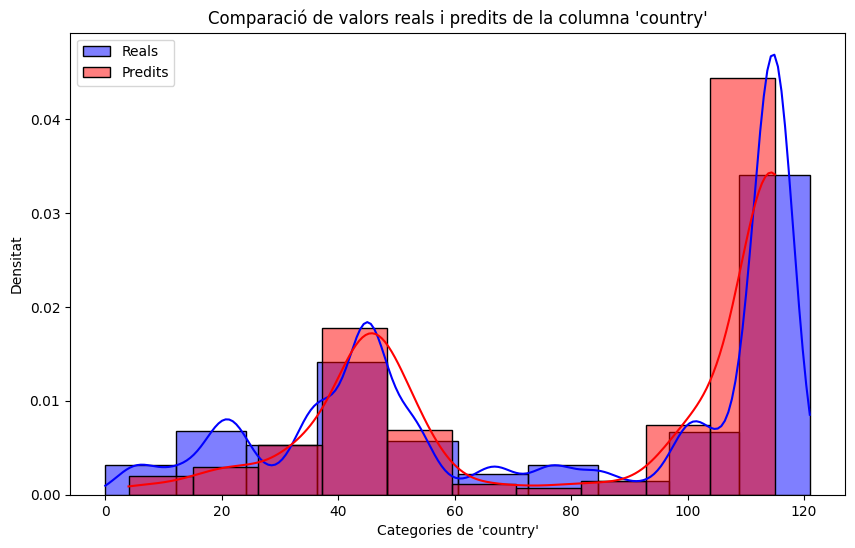

In [119]:
atributs = ['type', 'title', 'director', 'cast', 'release_year', 'rating', 'duration', 'listed_in', 'description']

label_encoders = {}
for column in atributs:  
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])  
    label_encoders[column] = le

known_country = df[df['country'].notnull()]
unknown_country = df[df['country'].isnull()]

le_country = LabelEncoder()
known_country['country'] = le_country.fit_transform(known_country['country'])

X_train = known_country.drop('country', axis=1)
y_train = known_country['country']
X_unknown = unknown_country.drop('country', axis=1)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

predicted_countries = rfc.predict(X_unknown)
predicted_countries = le_country.inverse_transform(predicted_countries)

df.loc[df['country'].isnull(), 'country'] = predicted_countries

plt.figure(figsize=(10, 6))
sns.histplot(known_country['country'], color='blue', label='Reals', kde=True, stat='density', bins=10)
sns.histplot(le_country.transform(predicted_countries), color='red', label='Predits', kde=True, stat='density', bins=10)

plt.legend()
plt.title("Comparació de valors reals i predits de la columna 'country'")
plt.xlabel("Categories de 'country'")
plt.ylabel("Densitat")
plt.show()

for column, le in label_encoders.items():
    df[column] = le.inverse_transform(df[column])


In [113]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director', 'cast']
  
Columnes amb nans i els seus percentatges:

director    25.071921
cast         1.062592
dtype: float64


Per eliminar els valors nuls dels atributs **Cast i Director** en comptes d'utilitzar Random Forest Classifier, utilitzem **KNN Imputer**, ja que hi ha un nombre molt gran d'actors i directors. 

In [77]:
atribtus = ['type', 'release_year', 'country', 'rating', 'duration', 'listed_in']

label_encoders = {}

for col in atribtus:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

cast_mapping = {name: idx for idx, name in enumerate(df['cast'].value_counts().index, 1)}
df['cast'] = df['cast'].map(cast_mapping)

knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = knn_imputer.fit_transform(df[atribtus + ['cast']])

df_imputed = pd.DataFrame(df_imputed, columns=atribtus + ['cast'])
for col in atribtus + ['cast']:
    df[col] = df_imputed[col]
    
reverse_cast_mapping = {v: k for k, v in cast_mapping.items()}
df['cast'] = df['cast'].apply(lambda x: np.nan if np.isnan(x) else reverse_cast_mapping.get(int(x), np.nan))
for column, le in label_encoders.items():
    if column in df.columns:
        df[column] = le.inverse_transform(df[column].astype(int))

In [78]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist() 

Tenim nans en els atributs:
['director']
  
Columnes amb nans i els seus percentatges:

director    25.071921
dtype: float64


In [79]:
atributs = ['type', 'cast', 'country', 'release_year', 'rating', 'duration', 'listed_in']
label_encoders = {}

for col in atributs:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  

director_mapping = {name: idx for idx, name in enumerate(df['director'].dropna().unique())}
reverse_director_mapping = {v: k for k, v in director_mapping.items()}
df['director'] = df['director'].map(director_mapping)

df['director'] = df['director'].fillna(-1)
knn_imputer = KNNImputer(n_neighbors=10, missing_values=-1)
df_imputed = knn_imputer.fit_transform(df[atributs + ['director']])
df_imputed = pd.DataFrame(df_imputed, columns=atributs + ['director'])

df_imputed['director'] = df_imputed['director'].round().astype(int) 
df_imputed['director'] = df_imputed['director'].map(reverse_director_mapping)  

for col in atributs:
    df_imputed[col] = label_encoders[col].inverse_transform(df_imputed[col].round().astype(int))

df[atributs + ['director']] = df_imputed[atributs + ['director']]

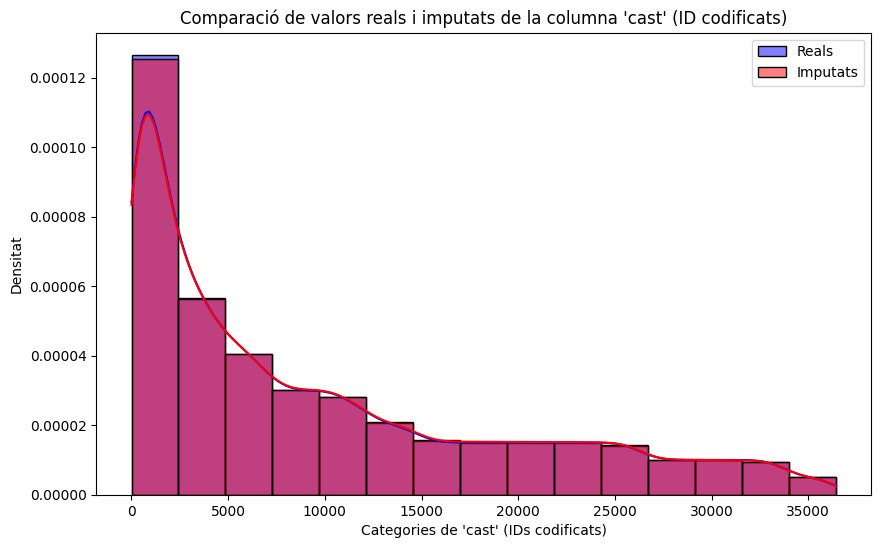

In [120]:
atribtus = ['type', 'country', 'release_year', 'rating', 'duration', 'listed_in']

# Pas 1: Codificació de les columnes categòriques
label_encoders = {}

for col in atribtus:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Pas 2: Codificació individual per a la columna 'cast'
cast_mapping = {name: idx for idx, name in enumerate(df['cast'].value_counts().index, 1)}
df['cast'] = df['cast'].map(cast_mapping)

# Pas 3: Imputació KNN
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = knn_imputer.fit_transform(df[atribtus + ['cast']])

# Convertir el resultat a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=atribtus + ['cast'])

# Pas 4: Generació del gràfic (ABANS de decodificar les dades)
# Dividim els valors reals i imputats
real_cast = df[df['cast'].notnull()]['cast']
imputed_cast = df_imputed['cast']

# Gràfic
plt.figure(figsize=(10, 6))
sns.histplot(real_cast, color='blue', label='Reals', kde=True, stat='density', bins=15)
sns.histplot(imputed_cast, color='red', label='Imputats', kde=True, stat='density', bins=15)

# Etiquetes i títols
plt.legend()
plt.title("Comparació de valors reals i imputats de la columna 'cast' (ID codificats)")
plt.xlabel("Categories de 'cast' (IDs codificats)")
plt.ylabel("Densitat")
plt.show()

# Pas 5: Reconstrucció de les dades (DESPRÉS del gràfic)
for col in atribtus + ['cast']:
    df[col] = df_imputed[col]

reverse_cast_mapping = {v: k for k, v in cast_mapping.items()}
df['cast'] = df['cast'].apply(lambda x: np.nan if np.isnan(x) else reverse_cast_mapping.get(int(x), np.nan))

for column, le in label_encoders.items():
    if column in df.columns:
        df[column] = le.inverse_transform(df[column].astype(int))

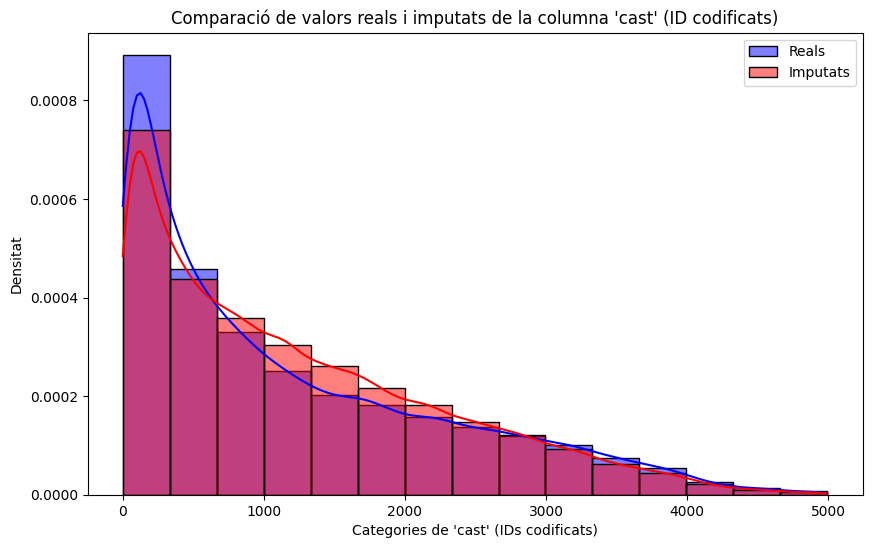

In [121]:
atribtus = ['type', 'country', 'cast', 'release_year', 'rating', 'duration', 'listed_in']

# Pas 1: Codificació de les columnes categòriques
label_encoders = {}

for col in atribtus:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Pas 2: Codificació individual per a la columna 'cast'
cast_mapping = {name: idx for idx, name in enumerate(df['director'].value_counts().index, 1)}
df['director'] = df['director'].map(cast_mapping)

# Pas 3: Imputació KNN
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = knn_imputer.fit_transform(df[atribtus + ['director']])

# Convertir el resultat a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=atribtus + ['director'])

# Pas 4: Generació del gràfic (ABANS de decodificar les dades)
# Dividim els valors reals i imputats
real_cast = df[df['director'].notnull()]['director']
imputed_cast = df_imputed['director']

# Gràfic
plt.figure(figsize=(10, 6))
sns.histplot(real_cast, color='blue', label='Reals', kde=True, stat='density', bins=15)
sns.histplot(imputed_cast, color='red', label='Imputats', kde=True, stat='density', bins=15)

# Etiquetes i títols
plt.legend()
plt.title("Comparació de valors reals i imputats de la columna 'cast' (ID codificats)")
plt.xlabel("Categories de 'cast' (IDs codificats)")
plt.ylabel("Densitat")
plt.show()

# Pas 5: Reconstrucció de les dades (DESPRÉS del gràfic)
for col in atribtus + ['director']:
    df[col] = df_imputed[col]

reverse_cast_mapping = {v: k for k, v in cast_mapping.items()}
df['director'] = df['director'].apply(lambda x: np.nan if np.isnan(x) else reverse_cast_mapping.get(int(x), np.nan))

for column, le in label_encoders.items():
    if column in df.columns:
        df[column] = le.inverse_transform(df[column].astype(int))

In [80]:
print(cast_mapping)
print(director_mapping)

{'Liam Neeson': 1, 'Alfred Molina': 2, 'John Krasinski': 3, 'Salma Hayek': 4, 'Frank Langella': 5, 'Anupam Kher': 6, 'John Rhys-Davies': 7, 'Shah Rukh Khan': 8, 'Naseeruddin Shah': 9, 'Radhika Apte': 10, 'David Attenborough': 11, 'James Franco': 12, 'Quvenzhané Wallis': 13, 'Tara Strong': 14, 'James Faulkner': 15, 'Jim Broadbent': 16, 'Akshay Kumar': 17, 'Paresh Rawal': 18, 'Om Puri': 19, 'Paul Giamatti': 20, 'Ben Whishaw': 21, 'Luci Christian': 22, 'Yuki Kaji': 23, 'Amitabh Bachchan': 24, 'Boman Irani': 25, 'Takahiro Sakurai': 26, 'Nawazuddin Siddiqui': 27, 'John Cleese': 28, 'Kareena Kapoor': 29, 'Halle Berry': 30, 'Hugo Weaving': 31, 'John Swasey': 32, 'Andy McAvin': 33, 'Anton Yelchin': 34, 'Keith David': 35, 'Fred Armisen': 36, 'Kay Kay Menon': 37, 'Donnie Yen': 38, 'Jackie Chan': 39, 'Willem Dafoe': 40, 'Jim Sturgess': 41, 'Stellan Skarsgård': 42, 'Gulshan Grover': 43, 'Fred Tatasciore': 44, 'Guy Pearce': 45, 'Amrish Puri': 46, 'Anil Kapoor': 47, 'Daisuke Ono': 48, 'Priyanka Chop

In [81]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist() 

Tenim nans en els atributs:
[]
  
Columnes amb nans i els seus percentatges:

Series([], dtype: float64)


### **3.3 AGRUPACIÓ**

In [82]:
unique_genres = set(genre.strip() for genres in df['listed_in'] for genre in genres.split(','))
print(len(unique_genres))
print(unique_genres)


42
{'TV Sci-Fi & Fantasy', 'Korean TV Shows', 'Thrillers', 'Docuseries', 'Horror Movies', 'Comedies', 'International TV Shows', 'Anime Features', 'TV Shows', 'International Movies', 'Cult Movies', 'Classic & Cult TV', 'TV Action & Adventure', 'Sports Movies', 'TV Comedies', 'LGBTQ Movies', 'Faith & Spirituality', 'Independent Movies', 'Music & Musicals', 'TV Dramas', 'Action & Adventure', 'Sci-Fi & Fantasy', 'Stand-Up Comedy', 'Dramas', 'Teen TV Shows', 'Reality TV', 'Stand-Up Comedy & Talk Shows', 'Romantic TV Shows', 'TV Mysteries', 'TV Horror', 'Science & Nature TV', 'Children & Family Movies', 'TV Thrillers', 'British TV Shows', 'Crime TV Shows', 'Classic Movies', "Kids' TV", 'Spanish-Language TV Shows', 'Romantic Movies', 'Documentaries', 'Movies', 'Anime Series'}


In [83]:
group_mapping = {
    'Horror': ['Thrillers', 'Horror Movies'],
    'TV Horror': ['TV Horror', 'Crime TV Shows', 'TV Mysteries', 'TV Thrillers'],
    'Drama and romance': ['Dramas', 'Romantic Movies', 'Independent Movies', 'Movies'],
    'TV Drama and romance': ['TV Dramas', 'Romantic TV Shows', 'Teen TV Shows'],
    'Comedy': ['Comedies', 'Stand-Up Comedy'],
    'TV Comedy': ['TV Comedies', 'Stand-Up Comedy & Talk Shows'],
    'International': ['International Movies'],
    'TV International': ['International TV Shows', 'British TV Shows', 'Spanish-Language TV Shows', 'Korean TV Shows'],
    'Family': ['Children & Family Movies'],
    'TV Family': ["Kids' TV"],
    'Fantasy': ['Sci-Fi & Fantasy'],
    'TV Fantasy': ['TV Sci-Fi & Fantasy'],
    'Action & Adventure': ['Action & Adventure'],
    'TV Action & Adventure': ['TV Action & Adventure'],
    'Documentaries & education': ['Documentaries', 'Faith & Spirituality'],
    'TV Documentaries & education': ['Docuseries', 'Science & Nature TV'],
    'Anime': ['Anime Features'],
    'TV Anime': ['Anime Series'],
    'Music': ['Music & Musicals'],
    'Sports': ['Sports Movies'],
    'Classic & cult': ['Classic Movies', 'Cult Movies', 'LGBTQ Movies'],
    'TV Classic & Cult': ['Classic & Cult TV'],
    'TV Reality': ['TV Shows', 'Reality TV']
}

def group_categories(row, group_mapping):
    categories = row.split(',') 
    new_categories = []
    
    for category in categories:
        category = category.strip()  
        matched = False
        for group, values in group_mapping.items():
            if category in values:  
                new_categories.append(group)  
                matched = True
                break  
        if not matched:
            new_categories.append(category)  
    
    return ','.join(new_categories)  

df['listed_in'] = df['listed_in'].apply(lambda x: group_categories(x, group_mapping))

### **3.3 NORMALITZACIÓ**

### **3.4 VISUALITZACIÓ DELS ATRIBUTS**

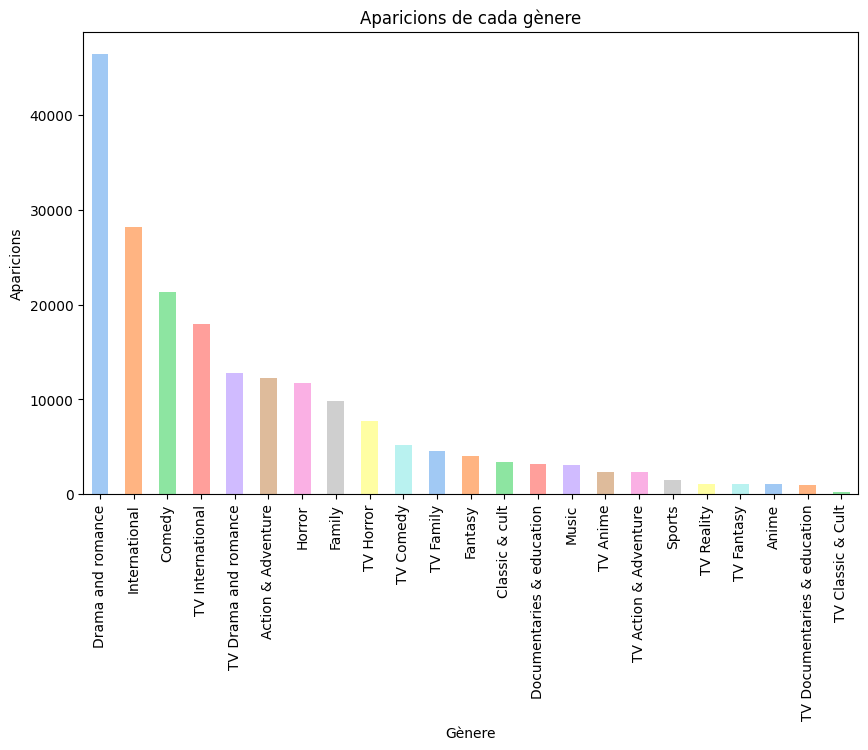

In [84]:
all_genres = [genre.strip() for genres in df['listed_in'] for genre in genres.split(',')]

genre_counts = pd.Series(all_genres).value_counts()
colors = sns.color_palette("pastel", len(genre_counts))

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada gènere")
plt.xlabel("Gènere")
plt.ylabel("Aparicions")
plt.show()


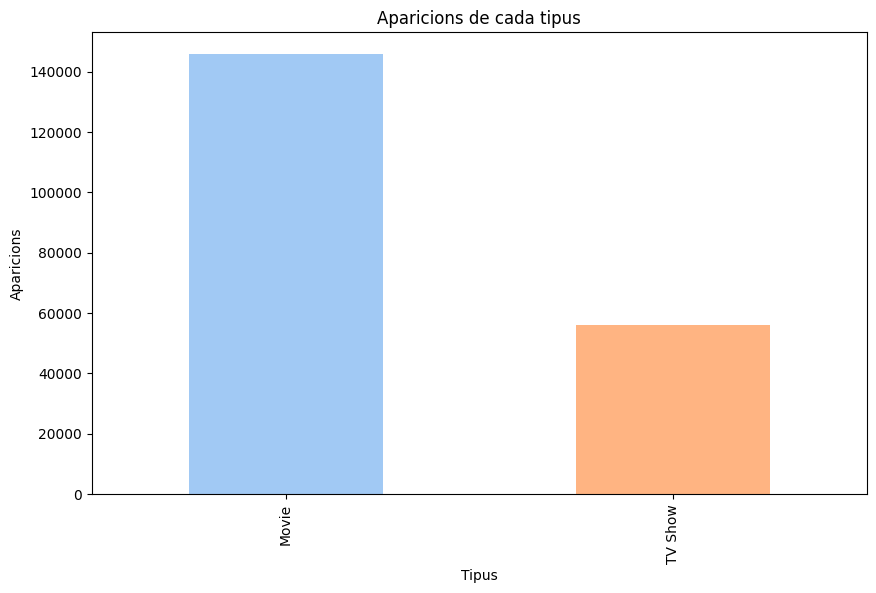

In [85]:
types = [genre.strip() for genres in df['type'] for genre in genres.split(',')]
type_counts = pd.Series(types).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada tipus")
plt.xlabel("Tipus")
plt.ylabel("Aparicions")
plt.show()

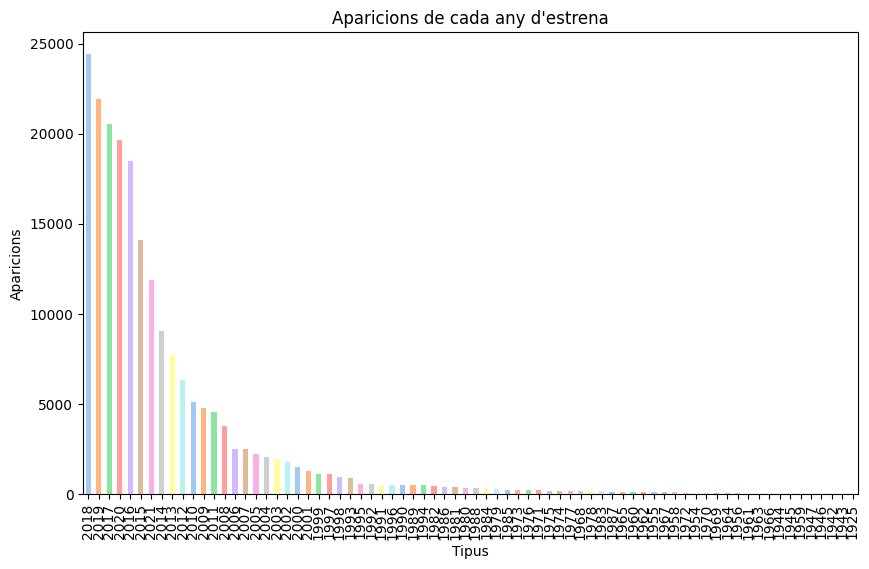

In [86]:
release_years = [genre.strip() for genres in df['release_year'] for genre in genres.split(',')]
type_counts = pd.Series(release_years).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada any d'estrena")
plt.xlabel("Tipus")
plt.ylabel("Aparicions")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


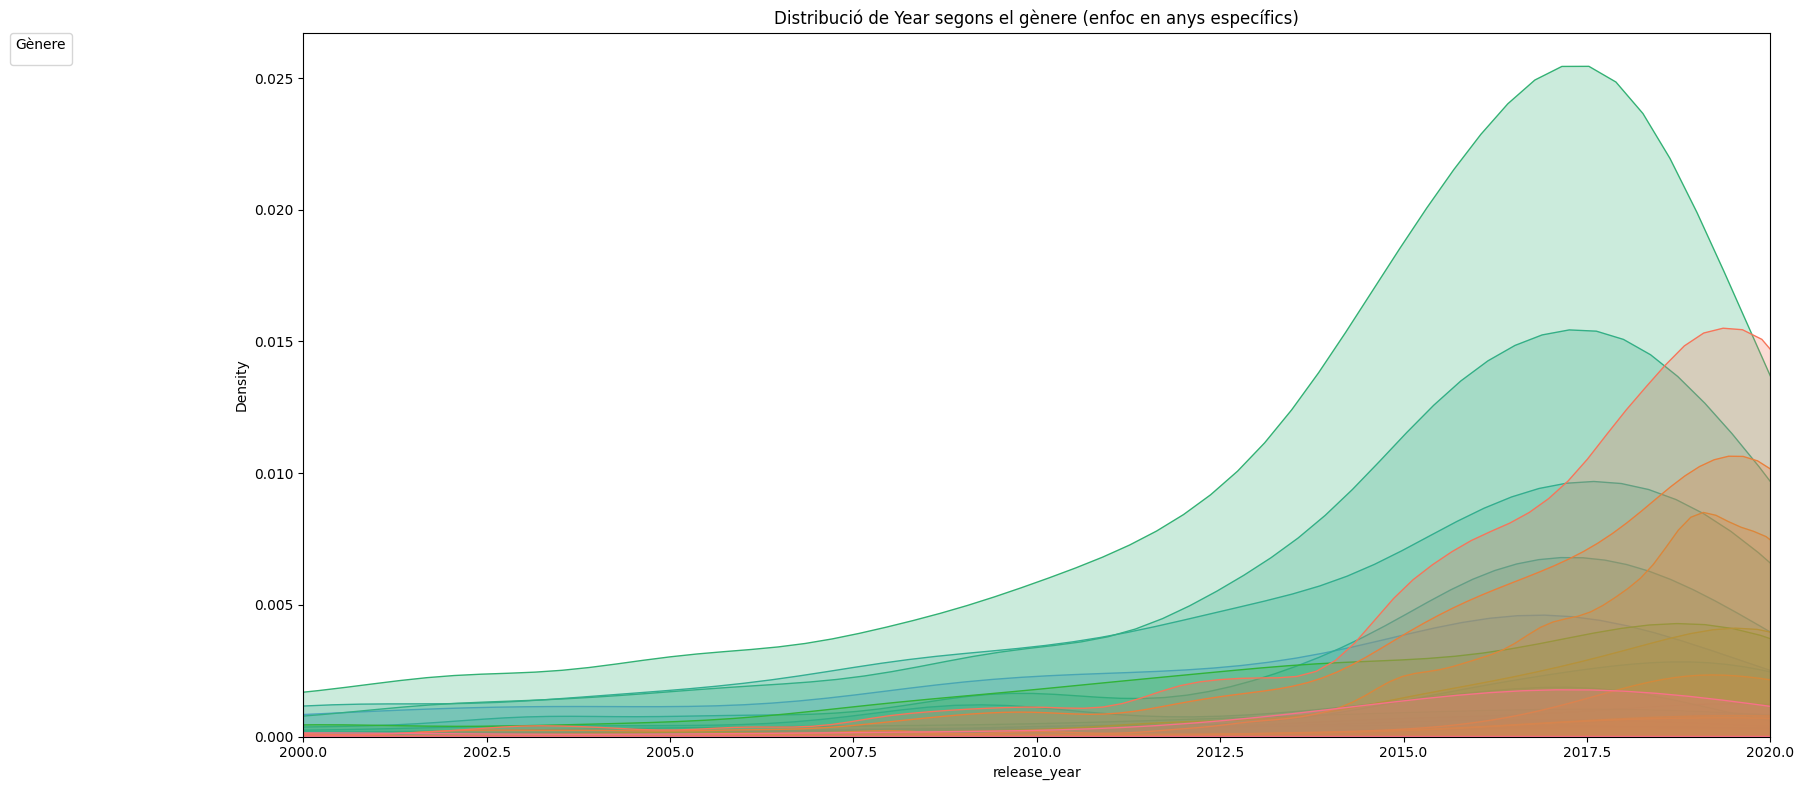

In [87]:
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

# Separa i ordena els gèneres
df['listed_in'] = df['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

# Explota els gèneres en files separades
df_copia = df.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

fig, axes = plt.subplots(1, 1, figsize=(18, 8))

# Gràfic KDE
sns.kdeplot(data=df_copia, x='release_year', hue='listed_in', fill=True, ax=axes)

# Establim un límit específic per a l'eix X
axes.set_xlim(2000, 2020)  # Ajusta els anys segons el rang que vulguis destacar

# Configura la llegenda a l'esquerra del gràfic
axes.legend(title="Gènere", bbox_to_anchor=(-0.2, 1), loc='upper left', borderaxespad=0)

plt.title("Distribució de Year segons el gènere (enfoc en anys específics)")
plt.tight_layout()  # Assegura que tot s'ajusti dins de la figura
plt.show()


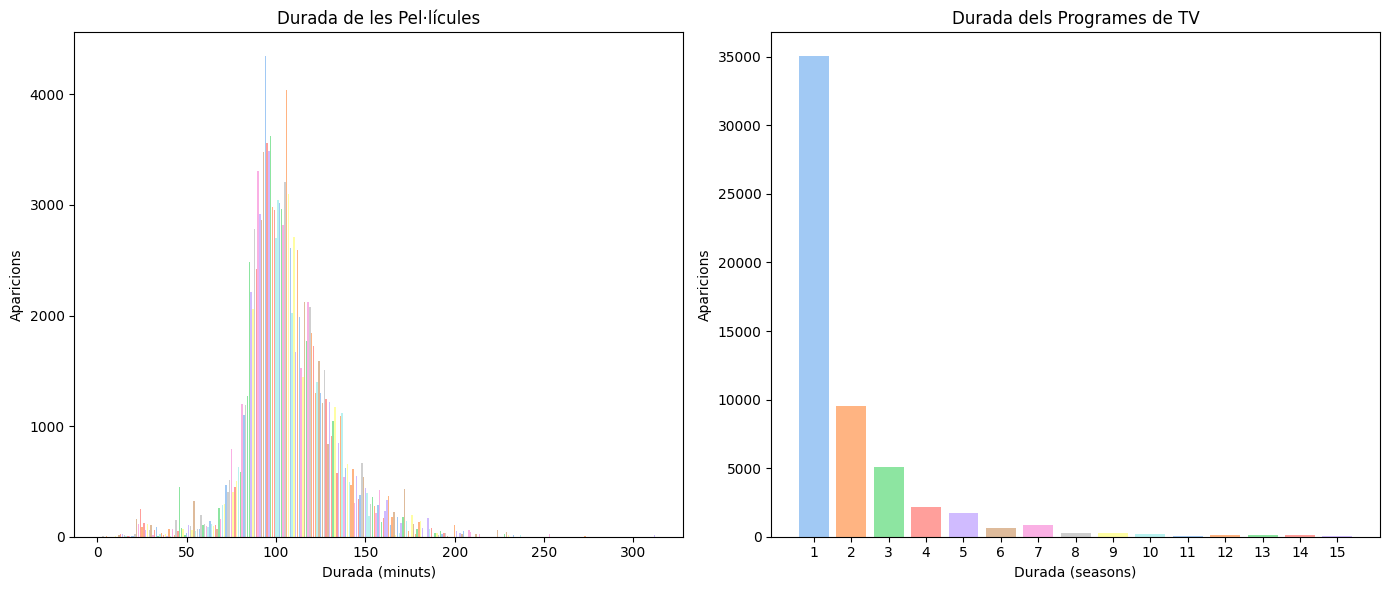

In [88]:
movie_df = df[df['type'] == 'Movie']
tv_show_df = df[df['type'] == 'TV Show']

movie_duration = movie_df['duration'].str.replace(' min', '').astype(int)
tv_show_duration = tv_show_df['duration'].str.replace(r'[^0-9]', '', regex=True).astype(int)

movie_duration_counts = movie_duration.value_counts()
tv_show_duration_counts = tv_show_duration.value_counts()

movie_colors = sns.color_palette("pastel", len(movie_duration_counts))
tv_show_colors = sns.color_palette("pastel", len(tv_show_duration_counts))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(movie_duration_counts.index, movie_duration_counts.values, color=movie_colors)
axes[0].set_title("Durada de les Pel·lícules")
axes[0].set_xlabel("Durada (minuts)")
axes[0].set_ylabel("Aparicions")

tv_show_duration_counts_sorted = tv_show_duration_counts.sort_index()  

axes[1].bar(range(1, len(tv_show_duration_counts_sorted) + 1), tv_show_duration_counts_sorted.values, color=tv_show_colors)
axes[1].set_title("Durada dels Programes de TV")
axes[1].set_xlabel("Durada (seasons)")
axes[1].set_ylabel("Aparicions")
axes[1].set_xticks(range(1, len(tv_show_duration_counts_sorted) + 1))
axes[1].set_xticklabels(range(1, len(tv_show_duration_counts_sorted) + 1))

plt.tight_layout()
plt.show()


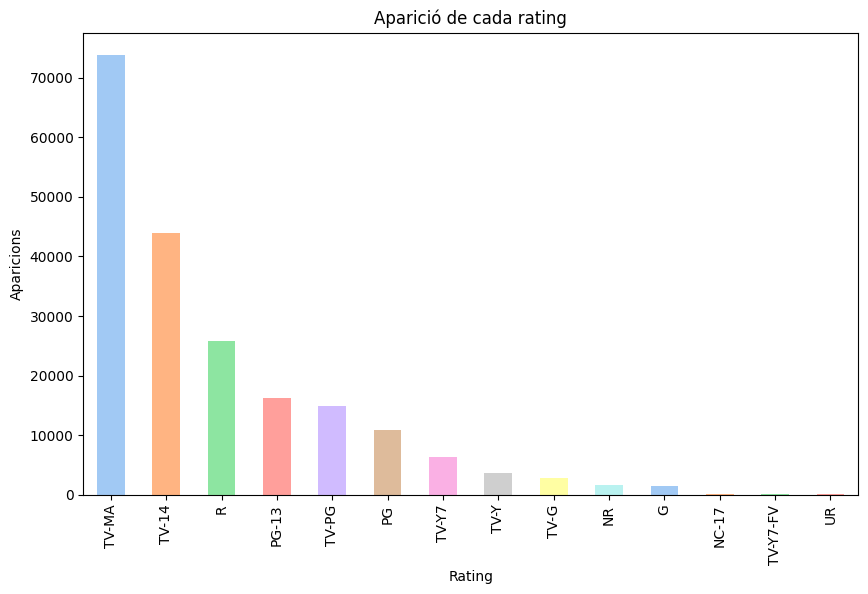

In [89]:
ratings = [genre.strip() for genres in df['rating'] for genre in genres.split(',')]
type_counts = pd.Series(ratings).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparició de cada rating")
plt.xlabel("Rating")
plt.ylabel("Aparicions")
plt.show()

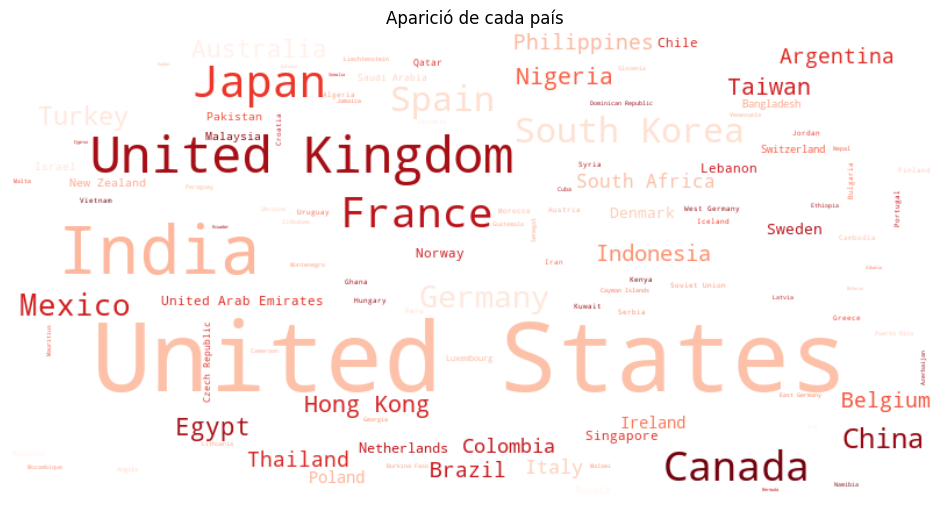

In [90]:
countries = [genre.strip() for genres in df['country'] for genre in genres.split(',')]
type_counts = pd.Series(countries).value_counts()

country_freq = type_counts.to_dict()

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(country_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Aparició de cada país")
plt.show()

Per corroborar que el word cloud està be, mirem quins son els actors més comuns del dataset un cop feta la predicció dels nans.

In [91]:
actors_individuals = df['cast'].str.split(', ').explode()
top_10_individual_actors = actors_individuals.value_counts().head(10)

print(top_10_individual_actors)

cast
Liam Neeson         161
Alfred Molina       160
John Krasinski      139
Salma Hayek         130
Frank Langella      128
Anupam Kher         127
John Rhys-Davies    125
Shah Rukh Khan      108
Naseeruddin Shah    106
Radhika Apte        104
Name: count, dtype: int64


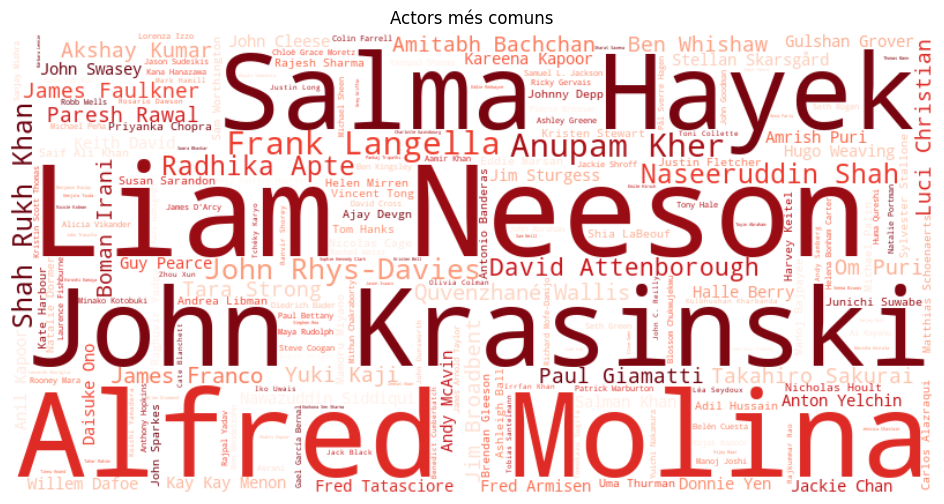

In [92]:
actor_counts = actors_individuals.value_counts()  
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(actor_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Actors més comuns")
plt.show()

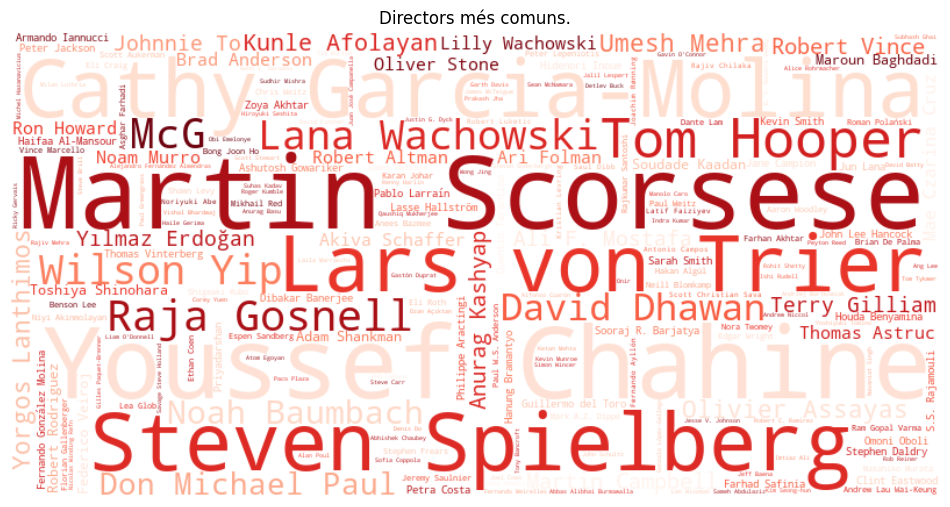

In [93]:
directors = [genre.strip() for genres in df['director'] for genre in genres.split(',')]
type_counts = pd.Series(directors).value_counts()

directors_freq = type_counts.to_dict()

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(directors_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Directors més comuns.")
plt.show()


### **3.4 CORRELACIÓ ENTRE ELS ATRIBUTS**

C:\Users\USER\AppData\Local\Temp\ipykernel_13896\3270076345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['release_year'] = d_f['release_year'].where(d_f['release_year'].isin(top_years), 'Other')
C:\Users\USER\AppData\Local\Temp\ipykernel_13896\3270076345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))


<Figure size 1500x800 with 0 Axes>

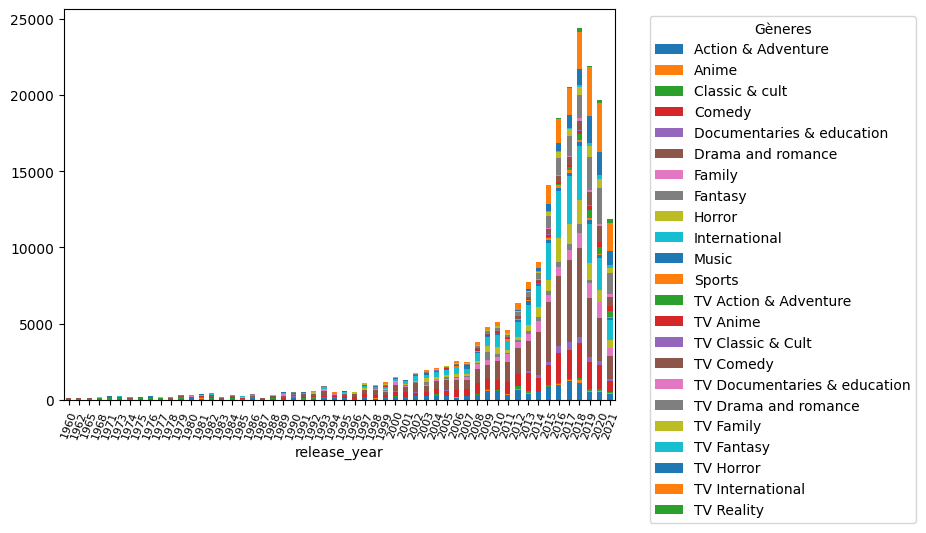

In [94]:
top_years = df['release_year'].value_counts().nlargest(54).index
d_f = df[df['release_year'].isin(top_years)]

d_f['release_year'] = d_f['release_year'].where(d_f['release_year'].isin(top_years), 'Other')

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['release_year', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout() 

plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


<Figure size 1500x800 with 0 Axes>

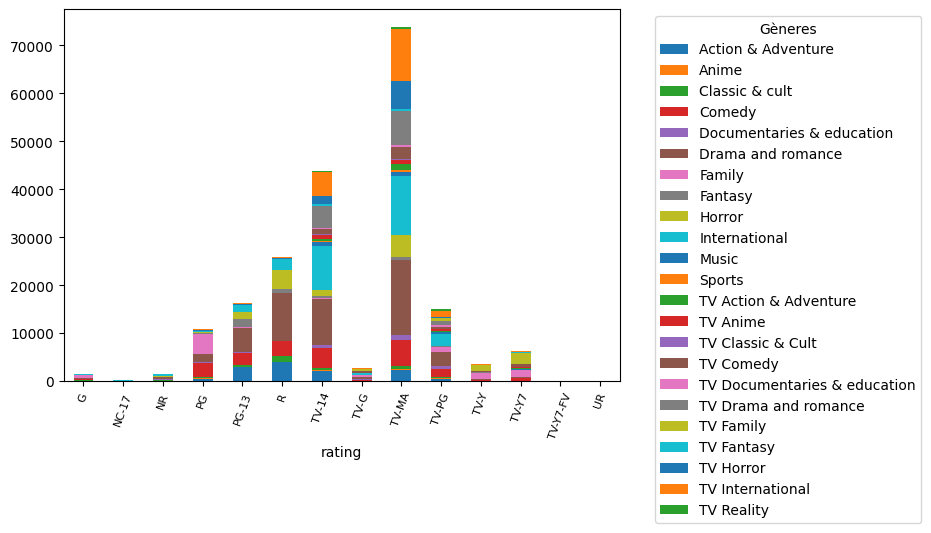

In [95]:
top_ratings = df['rating'].value_counts().nlargest(54).index
d_f = df[df['rating'].isin(top_ratings)]

d_f['rating'] = d_f['rating'].where(d_f['rating'].isin(top_ratings), 'Other')

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['rating', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout()  

plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_13896\814609895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['country'] = d_f['country'].where(d_f['country'].isin(top_countries), 'Other')
C:\Users\USER\AppData\Local\Temp\ipykernel_13896\814609895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))


<Figure size 1500x800 with 0 Axes>

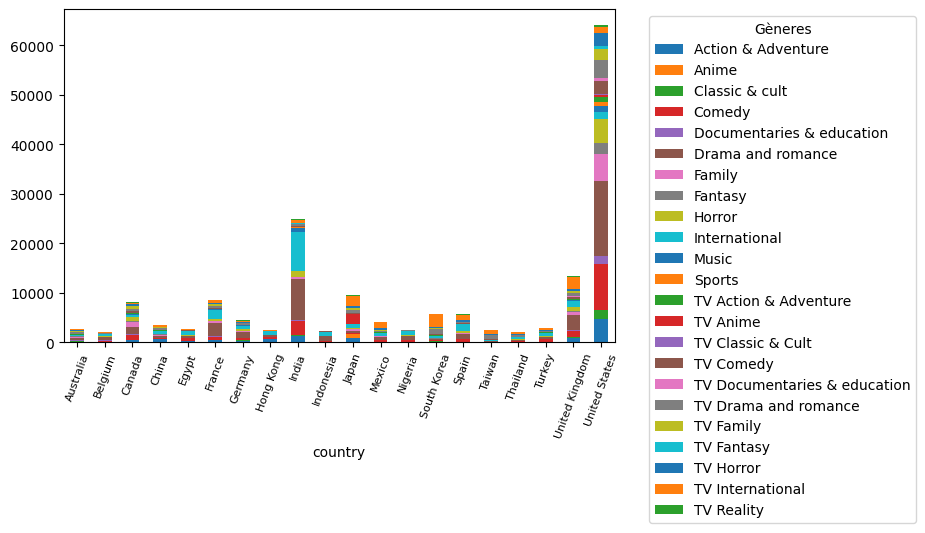

In [96]:
top_countries = df['country'].value_counts().nlargest(20).index
d_f = df[df['country'].isin(top_countries)]

d_f['country'] = d_f['country'].where(d_f['country'].isin(top_countries), 'Other')
d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(country=df_copia['country'].str.split(', '))
df_copia = df_copia.explode('country')  

df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['country', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_13896\1202718448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['cast'] = d_f['cast'].apply(lambda x: ', '.join([c for c in x.split(', ') if c in top_casts]))
C:\Users\USER\AppData\Local\Temp\ipykernel_13896\1202718448.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))


<Figure size 1500x800 with 0 Axes>

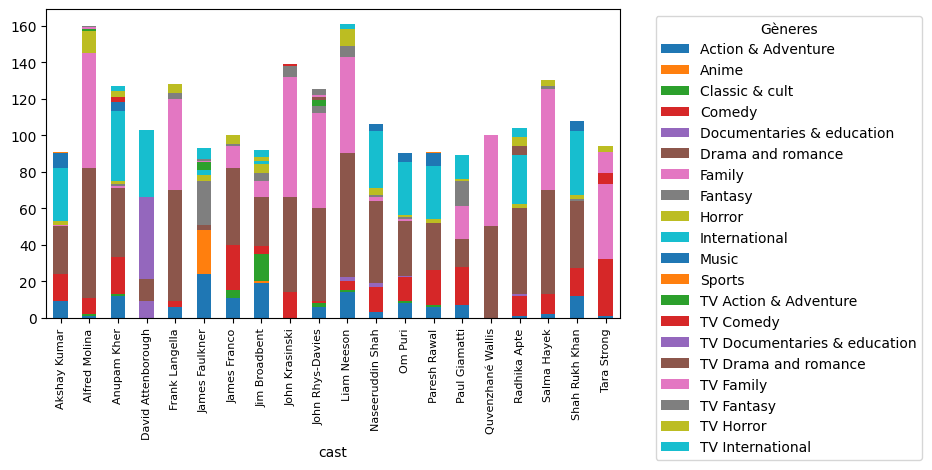

In [98]:
top_casts = df['cast'].dropna().str.split(', ').explode().value_counts().nlargest(20).index

d_f= df[df['cast'].notna() & df['cast'].str.split(', ').apply(lambda x: any(c in top_casts for c in x))]

d_f['cast'] = d_f['cast'].apply(lambda x: ', '.join([c for c in x.split(', ') if c in top_casts]))

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(cast=df_copia['cast'].str.split(', '))
df_copia = df_copia.explode('cast')  

df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['cast', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=90, fontsize=8)  
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_13896\1084726458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['director'] = d_f['director'].apply(lambda x: ', '.join([d for d in x.split(', ') if d in top_directors]))
C:\Users\USER\AppData\Local\Temp\ipykernel_13896\1084726458.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))


<Figure size 1500x800 with 0 Axes>

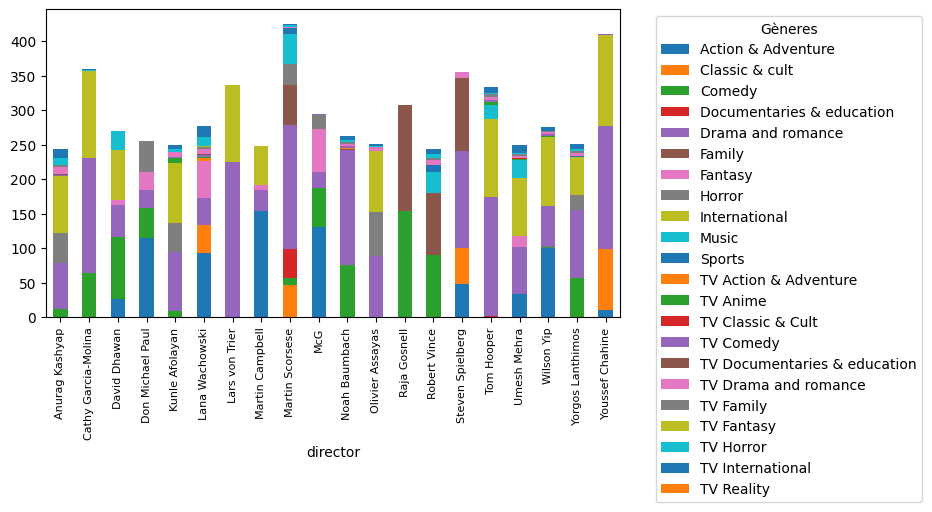

In [99]:
top_directors = df['director'].dropna().str.split(', ').explode().value_counts().nlargest(20).index

d_f = df[df['director'].notna() & df['director'].str.split(', ').apply(lambda x: any(d in top_directors for d in x))]

d_f['director'] = d_f['director'].apply(lambda x: ', '.join([d for d in x.split(', ') if d in top_directors]))

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(director=df_copia['director'].str.split(', '))
df_copia = df_copia.explode('director')

df_copia = df_copia[df_copia['director'].isin(top_directors)]

df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')


data = df_copia.groupby(['director', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8)) 
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=90, fontsize=8)  
plt.tight_layout()  


plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


<Figure size 1500x800 with 0 Axes>

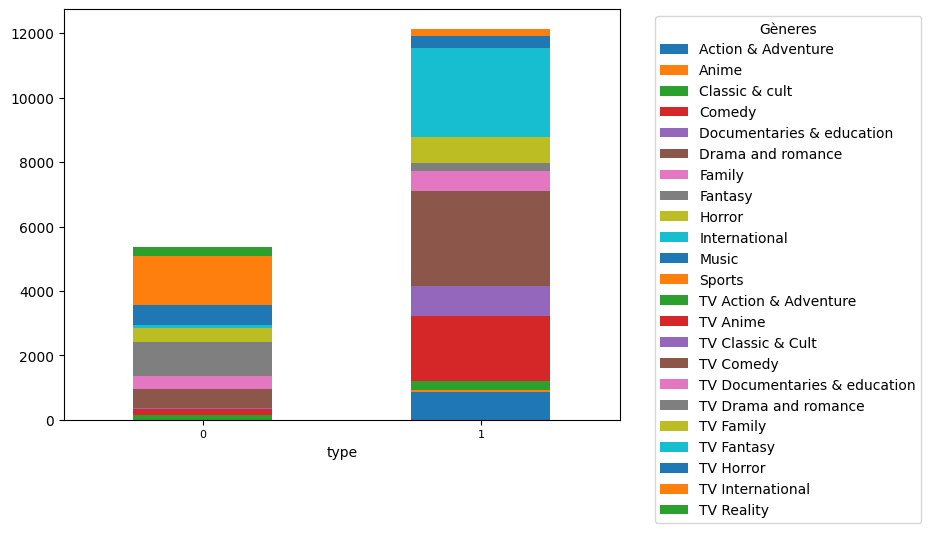

In [93]:
types = df['type'].value_counts().nlargest(54).index
d_f = df[df['type'].isin(types)]

d_f['type'] = d_f['type'].where(d_f['type'].isin(types), 'Other')

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['type', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8)) 
data.plot(kind='bar', stacked=True, legend=False) 
plt.xticks(rotation=0, fontsize=8)  
plt.tight_layout()  

plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


### **3.2 ENCODING**

A continuació fem encoding dels artributs **Type** i **Rating**.

In [23]:
df['type'] = df['type'].map({'TV Show': 0, 'Movie': 1})
print(df['type'])

0       1
1       0
2       0
3       0
4       0
       ..
8802    1
8803    0
8804    1
8805    1
8806    1
Name: type, Length: 8807, dtype: int64


In [24]:
df['rating'] = df['rating'].map({'PG-13': 0, 'TV-MA': 1, 'PG':2, 'TV-14':3, 'TV-PG':4, 'TV-Y':5, 'TV-Y7':6, 'R':7, 'TV-G':8, 'G':9, 'NC-17':10, 'NR':11, 'TV-Y7-FV':12, 'UR':13 })
print(df['rating'])

0       0
1       1
2       1
3       1
4       1
       ..
8802    7
8803    6
8804    7
8805    2
8806    3
Name: rating, Length: 8807, dtype: int64


# **4. METRIC SELECTION**

### **4.1 AVALUACIÓ I SEL·LECCIÓ DE LES MÈTRIQUES**

### **4.2 REPRESENTACIÓ GRÀFICA**

# **5. HYPERPARAMETER SELECTION**

# **6. DATA TRAINNING**

# **7. RECCOMENDATION**

Historial de visualització: Netflix analitza quins títols has vist (pel·lícules, sèries, documentals), el temps que hi has dedicat i si els has acabat o no. Si acabes una sèrie, es considera que t’ha agradat més que si només en veus un episodi o l'abandones a mitges.

Categories de gènere i temàtica: Cada títol a Netflix està etiquetat amb múltiples categories (per exemple, "comèdia romàntica", "drama policíac", "ciència ficció"). El sistema detecta els gèneres i subgèneres que més consumeixes per recomanar-te contingut similar.

Valoracions i reaccions dels usuaris: Netflix també considera si fas clic a “M'agrada” o “No m'agrada” en certs títols. Aquestes interaccions ajuden a perfilar millor el teu gust.

Moment i context de visualització: L'algoritme pot captar patrons en els moments en què consumes determinats tipus de contingut. Per exemple, potser prefereixes veure sèries llargues durant el cap de setmana i pel·lícules d'acció a la nit.

Popularitat a la teva regió: Netflix té en compte les tendències locals. Si hi ha títols que estan de moda en el teu país o regió, tenen més probabilitat d'aparèixer en les recomanacions, fins i tot si no segueixen les teves preferències històriques.

Anàlisi de similitud d'usuaris (collaborative filtering): Mitjançant tècniques de “filtratge col·laboratiu”, Netflix compara el teu perfil amb altres usuaris amb gustos similars i recomana contingut que altres usuaris amb preferències semblants han vist i valorat positivament.

Contingut similar: Netflix també pot fer servir un model de "content-based filtering", que recomana continguts similars als que ja has vist. Això es basa en característiques de les pel·lícules i sèries, com actors, directors o gèneres comuns.

type: Aquest atribut especifica si el contingut és una pel·lícula o una sèrie. Pot ajudar a filtrar recomanacions segons el tipus que l'usuari prefereixi, ja que algunes persones poden tenir una preferència clara per un tipus de format sobre l'altre.

listed_in: Aquest atribut representa els gèneres o categories (com comèdia, drama, acció, documentals, etc.) en què s’emmarca el contingut. És probablement dels més importants, ja que els usuaris tenen tendència a preferir certs gèneres i subgèneres.

cast i director: Aquests atributs són útils perquè moltes persones tenen preferències per certs actors o directors. Si l'usuari ha vist diversos continguts amb el mateix actor o director, es pot deduir que és una característica atractiva per a ell.

country: El país de producció pot influir en les preferències, ja que pot indicar una preferència per continguts d'una cultura o regió específica. Això és especialment rellevant en les plataformes globals com Netflix, que ofereixen continguts d'arreu del món.

release_year: L'any d'estrena pot ajudar a recomanar contingut segons preferències de dècades o períodes concrets. Si algú prefereix contingut modern o, per contra, pel·lícules i sèries clàssiques, aquest atribut és rellevant.

duration: Tot i que no sempre és clau, la durada pot ser útil per ajustar les recomanacions en funció de l'estil de visualització de l'usuari. Per exemple, si algú sol veure continguts més curts, es poden prioritzar les pel·lícules o sèries amb episodis més breus.

rating: La classificació per edat pot ser útil si l'algoritme detecta preferències per certs nivells de maduresa del contingut (com "PG-13", "R", etc.). També pot ser útil si es volen fer recomanacions adequades per a una audiència de certa edat.

description: Tot i que no és un atribut directe per a les recomanacions, es podria analitzar amb processament de llenguatge natural per extreure paraules clau que permetin recomanar contingut amb temàtiques similars.

Atributs menys rellevants:
show_id: És només un identificador únic per a cada registre i no aporta informació sobre les preferències de l'usuari.
title: En general, el títol per si sol no aporta informació rellevant per a la recomanació, tot i que podria utilitzar-se com a punt de partida per buscar patrons en sèries o franquícies similars.
En conjunt, podries crear un sistema de recomanació combinant factors com els gèneres (listed_in), el tipus de contingut (type), els actors i directors (cast, director), el país de producció (country), i l'any d'estrena (release_year) per fer una proposta ajustada als interessos de l'usuari.